# Compare published and modelled data end use energy demand in the three Euro-Calliope Austrian subregions

In [3]:
import sys
import os

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import statsmodels.api as sm
sys.path.append('../src/construct/')
import util
import annual_heat_demand

idx = pd.IndexSlice

data_path = '../data/'

subsectors = {
    'Chemical & petrochemical': 'Chemicals Industry',
    'Food, beverages & tobacco': 'Food, beverages and tobacco',
    'Iron & steel': 'Iron and steel',
    'Machinery': 'Machinery Equipment',
    'Non-ferrous metals': 'Non Ferrous Metals',
    'Non-metallic minerals': 'Non-metallic mineral products',
    'Not elsewhere specified (industry)': 'Other Industrial Sectors',
    'Mining & quarrying': 'Other Industrial Sectors',
    'Construction': 'Other Industrial Sectors',
    'Paper, pulp & printing': 'Pulp, paper and printing',
    'Textile & leather': 'Textiles and leather',
    'Transport equipment': 'Transport Equipment',
    'Wood & wood products': 'Wood and wood products',
}

In [4]:
subsectors = pd.read_csv(data_path + '/energy_balance_category_names.csv', index_col=0)
carriers = pd.read_csv(data_path + '/energy_balance_carrier_names.csv', index_col=0)
nuts2 = gpd.read_file('../build/administrative-borders-nuts.gpkg', layer='nuts2')
nuts3 = gpd.read_file('../build/administrative-borders-nuts.gpkg', layer='nuts3')
nuts3['nuts2'] = nuts3.id.str[:-1]

In [5]:
nuts2 = nuts2[nuts2.country_code == 'AUT']
nuts3 = nuts3[nuts3.country_code == 'AUT']

In [6]:
energy_balances = pd.read_csv('../build/annual_energy_balances.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)
subsectors = pd.read_csv(data_path + '/energy_balance_category_names.csv', index_col=0)
carriers = pd.read_csv(data_path + '/energy_balance_carrier_names.csv', index_col=0)
_subsectors = subsectors.jrc_idees.dropna().to_dict()
_subsectors['FC_IND_NFM_E'] = 'Metals'
_subsectors['FC_IND_IS_E'] = 'Metals'
_subsectors['FC_IND_PPP_E'] = 'Wood and paper'
_subsectors['FC_IND_WP_E'] = 'Wood and paper'

industry_energy_balances = (
    energy_balances
    .xs(('AT', 2014, 'TOTAL', 'TJ'), level=('country', 'year', 'carrier_code', 'unit'))
    .apply(util.tj_to_twh)
    .groupby(_subsectors).sum()
    .rename_axis(index='cat_name')
)

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Published Austrian data
[Austrian statistics](https://www.statistik.at/web_en/statistics/EnergyEnvironmentInnovationMobility/energy_environment/energy/useful_energy_analysis/index.html)

In [7]:
# Extract Austrian data
def get_at_end_use_df(year=None, region=None):
    files = {
        'AT': '066288',  # NUTS0
        'AT11': '066289',  # NUTS2
        'AT12': '066291',  # NUTS2
        'AT13': '066297',  # NUTS2
        'AT21': '066290',  # NUTS2
        'AT22': '066294',  # NUTS2
        'AT31': '066292',  # NUTS2
        'AT32': '066293',  # NUTS2
        'AT33': '066295',  # NUTS2
        'AT34': '066296'  # NUTS2
    }
    if region is not None:
        files = {region: files[region]}
    if year is not None:
        years = [year]
    else:
        years = range(2005, 2018)
    end_uses = []
    
    for region, filecode in files.items():
        for year in years:
            _end_use_demand = pd.read_excel(
                f'https://www.statistik.at/wcm/idc/idcplg?IdcService=GET_NATIVE_FILE&RevisionSelectionMethod=LatestReleased&dDocName={filecode}', 
                sheet_name=f'NEA {year}', usecols="U:AI", skiprows=30, header=None
            ).dropna()
            table_ends = _end_use_demand[_end_use_demand[20] == 'Peat'].index
            dfs = []

            for i in range(0, len(table_ends)):
                if i == 0:
                    _df = _end_use_demand.loc[:table_ends[i] + 1]
                else:
                    _df = _end_use_demand.loc[table_ends[i - 1] + 1:table_ends[i] + 1]

                _df = _df.set_index(20).drop(['Shares', 'TOTAL', 0], errors='ignore')
                _df.columns = _df.iloc[0].values
                _df.rename(
                    columns={'Indust. furnaces': 'Industrial furnaces',
                            'of which electochemical purp.': 'of which electochemical purposes'}, 
                    inplace=True
                )
                _df.index.set_names('carrier_name', inplace=True)
                _df = _df.assign(cat_name=_df.iloc[0].name)
                _df = _df.drop(_df.iloc[0].name).drop(['Other', 'Total'], axis=1)
                _df.columns = (
                    _df.columns
                    .str.lower()
                    .str.replace("of which ", "")
                    .str.replace(" & ", "_")
                    .str.replace(" ", "_")
                )
                _df = _df.set_index('cat_name', append=True)

                dfs.append(_df)
            end_uses.append(
                pd.concat(dfs, sort=True)
                .sort_index()
                .assign(region=region, year=year, unit='TJ')
                .set_index(['region', 'year', 'unit'], append=True)
            )
    return pd.concat(end_uses, sort=True)

In [8]:
at_end_use_df = get_at_end_use_df(year=2014)
at_stats_df = at_end_use_df.stack().sum(level=['cat_name', 'region']).unstack()

In [9]:
at_stats_intensity = at_stats_df.div(at_stats_df['AT'], axis=0).drop('AT', axis=1)#drop('MANUFACTURING INDUSTRIES IN TOTAL')
at_stats_intensity_gdf = nuts2.merge(at_stats_intensity.T, left_on='id', right_index=True)

# Emissions
[Hotmaps industrial site database](https://gitlab.com/hotmaps/industrial_sites/industrial_sites_Industrial_Database)

In [10]:
all_industrial_units = gpd.read_file('../build/all_industrial_ets_eprtr_sites.geojson')
# Map industries to Euro-calliope regions
industries_in_at = gpd.overlay(all_industrial_units, nuts2)
# Get contribution of region to each country's industrial emissions
regional_industry_emissions = industries_in_at.groupby(['Subsector', 'country_code', 'id']).sum()[['emissions']]
regional_industry_emissions['emissions_intensity'] = (
    regional_industry_emissions['emissions'] / 
    regional_industry_emissions['emissions'].sum(level=['Subsector', 'country_code'])
)
industry_emissions_intensity_gdf = (
    nuts2
    .set_index(['id', 'country_code'])
    .merge(
        regional_industry_emissions['emissions_intensity']
        .unstack('Subsector')
        .fillna(0),
        left_index=True, right_index=True
    )
    .reset_index()
)

# Industrial waste
[Industrial Emissions Directive 2010/75/EU and European Pollutant Release and Transfer Register Regulation (EC) No 166/2006](https://www.eea.europa.eu/data-and-maps/data/industrial-reporting-under-the-industrial)

In [11]:
waste_gdf = gpd.read_file('../build/industry_eprtr_waste_sites.geojson')
waste_in_at = gpd.overlay(waste_gdf, nuts2)
waste_in_at = waste_in_at.groupby(['id', 'subsector']).sum()['waste'].unstack('subsector')
regional_industry_waste = (
    nuts2
    .merge(
        waste_in_at
        .div(waste_in_at.sum())
        .fillna(0), 
        left_on='id', right_index=True
    )
)

# Business statistics
[Eurostat structural business statistics](https://ec.europa.eu/eurostat/web/products-datasets/product?code=sbs_r_nuts06_r2) and [business demography](https://ec.europa.eu/eurostat/web/products-datasets/-/bd_hgnace2_r3)

In [13]:
industry_activity = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/sbs_r_nuts06_r2.tsv.gz', delimiter='\t', index_col=0)
industry_activity.index = industry_activity.index.str.split(',', expand=True).rename(['cat_code', 'indicator', 'region'])

# Below only needed if trying to go down to NUTS3 regions, to build back up to EUROSPORES regions
#industry_enterprises = pd.read_csv(data_path + '/industry/bd_hgnace2_r3.tsv', delimiter='\t', index_col=0)
#industry_enterprises.index = industry_enterprises.index.str.split(',', expand=True).rename(['indicator', 'cat_code', 'region'])

industrial_activity_codes = pd.read_csv(
    data_path + '/industry/industry_activity_codes.csv', 
    skipfooter=7, index_col=0, header=0, engine='python'
).dropna(subset=['Eurostat sector'])

In [14]:
# V11210 == local units,  V16110 == persons employed,  	V13320 == wages and salaries
local_industry_units = industry_activity.xs('V11210', level='indicator').apply(util.to_numeric).loc[idx[industrial_activity_codes['Eurostat sector'].dropna().index, nuts2.id.values], :]
local_industry_units.columns = local_industry_units.columns.astype(int)
local_industry_units = local_industry_units.unstack().groupby(industrial_activity_codes['Eurostat sector'].to_dict()).sum().T

# Below only needed if trying to go down to NUTS3 regions, to build back up to EUROSPORES regions
#bar = foo.where(foo > 0).stack().unstack(0).reindex(nuts3_contrib.index.get_level_values('nuts2'))
#bar.index = nuts3_contrib.index.get_level_values('id')
#bar.columns = bar.columns.rename(['year', 'cat_name'])

#baz = bar.mul(nuts3_contrib.droplevel(1).align(bar)[0])
#foobar = baz.groupby(nuts3.set_index('id').reindex(baz.index).eurospores).sum()
#foobar.where(foobar > 0).dropna(how='all', axis=1).xs(2014, axis=1)

regional_industry_local_units = (
    nuts2
    .merge(
        local_industry_units.xs(2014)
        .div(local_industry_units.xs(2014).sum())
        .fillna(0), 
        left_on='id', right_index=True
    )
)

In [15]:
# V11210 == local units,  V16110 == persons employed,  	V13320 == wages and salaries
industry_employees = industry_activity.xs('V16110', level='indicator').apply(util.to_numeric).loc[idx[industrial_activity_codes['Eurostat sector'].dropna().index, nuts2.id.values], :]
industry_employees.columns = industry_employees.columns.astype(int)
industry_employees = industry_employees.unstack().groupby(industrial_activity_codes['Eurostat sector'].to_dict()).sum().T

regional_industry_employees = (
    nuts2
    .merge(
        industry_employees.xs(2013)
        .div(industry_employees.xs(2013).sum())
        .fillna(0), 
        left_on='id', right_index=True
    )
)

In [16]:
# V11210 == local units,  V16110 == persons employed,  	V13320 == wages and salaries
industry_wages = industry_activity.xs('V13320', level='indicator').apply(util.to_numeric).loc[idx[industrial_activity_codes['Eurostat sector'].dropna().index, nuts2.id.values], :]
industry_wages.columns = industry_wages.columns.astype(int)
industry_wages = industry_wages.unstack().groupby(industrial_activity_codes['Eurostat sector'].to_dict()).sum().T

regional_industry_wages = (
    nuts2
    .merge(
        industry_wages.xs(2013)
        .div(industry_wages.xs(2013).sum())
        .fillna(0), 
        left_on='id', right_index=True
    )
)

In [19]:
enterprises_df = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/bd_hgnace2_r3.tsv.gz', delimiter='\t', index_col=0)
enterprises_df.index = enterprises_df.index.str.split(',', expand=True).rename(['indicator', 'cat_code', 'region'])
enterprises_df.columns = enterprises_df.columns.astype(int)
industry_enterprises = enterprises_df.xs(('V11910', 'B-E')).loc[nuts2.id].apply(util.to_numeric)[2014]
enterprise_intensity = industry_enterprises.div(industry_enterprises.sum())

# Population
[Eurostat data](https://ec.europa.eu/eurostat/statistics-explained/index.php/Population_statistics_at_regional_level)

In [20]:
population_2014 = {
    'AT11': 287416,
    'AT12': 1625485,
    'AT13': 1766746,
    'AT21': 555881,
    'AT22': 1215246,
    'AT31': 1425422,
    'AT32': 534270,
    'AT33': 722038,
    'AT34': 375282
}

population_df = pd.Series(population_2014)
population_intensity = population_df.div(population_df.sum())
pop_density_df = population_df / nuts2.set_index('id').to_crs('epsg:3035').area
pop_density_intensity = pop_density_df.div(pop_density_df.sum())
area_pop_intensity = (1 / pop_density_df).div((1 / pop_density_df).sum())

# GDP

[Eurostat data](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=nama_10r_3gdp&lang=en)

In [21]:
nuts3_employment = pd.read_excel( # Data = 'employed persons', Data2 = 'employees'
   data_path + '/eu_employment_nuts3.xls', sheet_name='Data', skiprows=9, index_col=0
)
nuts3_employment.index = nuts3_employment.index.str.split(' - ', expand=True).droplevel([1, 2, 3])
nuts3_gdp =  pd.read_excel(
    data_path + '/eu_gdp_nuts3.xls', sheet_name='Data', skiprows=8, index_col=0
)
nuts3_gdp.index = nuts3_gdp.index.str.split(' - ', expand=True).droplevel([1, 2, 3])

gdp_df = nuts3_gdp.loc[nuts2.id, '2014']
gdp_intensity = gdp_df.div(gdp_df.sum())

# GVA
[Eurostat data](https://ec.europa.eu/eurostat/web/products-datasets/product?code=nama_10r_3gva)

In [22]:
gva_df = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nama_10r_3gva.tsv.gz', delimiter='\t', index_col=0)
gva_df.index = gva_df.index.str.split(',', expand=True).rename(['unit', 'cat_name', 'region'])
gva_df = gva_df.apply(util.to_numeric)
gva_at = gva_df.xs(('MIO_EUR', 'B-E')).loc[nuts2.id]['2014 ']
gva_intensity = gva_at.div(gva_at.sum())

# Freight loading
[Eurostat data](https://ec.europa.eu/eurostat/web/products-datasets/product?code=road_go_na_rl3g)

In [23]:
freight = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_na_rl3g.tsv.gz', delimiter='\t', index_col=0)
freight.index = freight.index.str.split(',', expand=True).rename(['subsector', 'unit', 'region'])
freight = freight.apply(util.to_numeric)

freight_sectors = {'GT03': 'Other Industrial Sectors',
'GT04': 'Food, beverages and tobacco',
'GT05': 'Textiles and leather',
'GT06': 'Wood and paper',
'GT08': 'Chemicals Industry',
'GT09': 'Non-metallic mineral products' ,
'GT10': 'Metals',
'GT11': 'Machinery Equipment',
'GT12': 'Transport Equipment',
'GT13': 'Other Industrial Sectors'}

freight_at = freight.groupby([freight_sectors, nuts3.set_index('id').nuts2.to_dict()], level=[0, 2]).sum()['2014 '].unstack('region')

#freight_at.loc['Pulp, paper and printing', :] = freight_at.loc['Wood and paper', :] * (local_energy.loc['Pulp, paper and printing'] / local_energy.loc[['Pulp, paper and printing', 'Wood and wood products']].sum())
#freight_at.loc['Wood and wood products', :] = freight_at.loc['Wood and paper', :] * (local_energy.loc['Wood and wood products'] / local_energy.loc[['Pulp, paper and printing', 'Wood and wood products']].sum())

# NUTS3 employment

[Eurostat data](https://ec.europa.eu/eurostat/web/products-datasets/product?code=nama_10r_3empers)

In [24]:
employment_df = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nama_10r_3empers.tsv.gz', delimiter='\t', index_col=0)
employment_df.index = employment_df.index.str.split(',', expand=True).rename(['unit', 'indicator', 'cat_name', 'region'])
employment_df.columns = employment_df.columns.astype(int)
employment_df = employment_df.apply(util.to_numeric)
employment_at = employment_df.xs(('THS', 'EMP')).loc[idx[['B-E', 'C'], nuts2.id], 2014].sum(level='region')
employment_intensity = employment_at.div(employment_at.sum())

In [ ]:
employment_nuts3= employment_df.xs(('THS', 'EMP')).loc[idx[['B-E', 'C'], nuts3.id], 2014].sum(level='region')
employment_energy_nuts3 = employment_nuts3.div(employment_nuts3.sum()).mul(industry_energy_balances.sum())

In [ ]:
(employment_energy_nuts3 + 0.3 * emissions_energy_nuts3.reindex(employment_energy_nuts3.index).fillna(0)).groupby(nuts3.set_index('id').nuts2).sum()

In [ ]:
emissions_energy_nuts3 = indicator_energy_use(
    gpd.overlay(all_industrial_units, nuts3)
    .groupby(['Subsector', 'id'])
    .sum()['emissions']
    .unstack(1)
    .rename(index={
        'Iron and steel': 'Metals',
        'Non Ferrous Metals': 'Metals',
        'Pulp, paper and printing': 'Wood and paper', #'Pulp, paper and printing',
        'Wood and wood products': 'Wood and paper',
    }).groupby(level=0).sum().rename_axis(index='subsector')
).sum()

# Compare results

In [273]:
at_stats = at_stats_df.rename(index={
    'Chemical and petrochemical industry': 'Chemicals Industry',
    'Construction': 'Other Industrial Sectors',
    'Food, tabacco and beverages': 'Food, beverages and tobacco',
    'Iron and steel': 'Metals',
    'Machinery': 'Machinery Equipment',
    'Mining and quarrying': 'Other Industrial Sectors',
    'Non ferrous metals': 'Metals',
    'Non metalic minerals': 'Non-metallic mineral products',
    'Non specified industry': 'Other Industrial Sectors',
    'Paper, pulp and print': 'Wood and paper', #'Pulp, paper and printing',
    'Wood and wood products': 'Wood and paper',
    'Transport equipment': 'Transport Equipment'
}).groupby(level=0).sum().drop('MANUFACTURING INDUSTRIES IN TOTAL').drop('AT', axis=1).rename_axis(index='subsector')

emissions = regional_industry_emissions['emissions'].droplevel('country_code').unstack().rename(index={
    'Iron and steel': 'Metals',
    'Non Ferrous Metals': 'Metals',
    'Pulp, paper and printing': 'Wood and paper', #'Pulp, paper and printing',
    'Wood and wood products': 'Wood and paper',
}).groupby(level=0).sum().rename_axis(index='subsector')

waste = waste_in_at.T.rename(index={
    'Iron and steel': 'Metals',
    'Mining': 'Other Industrial Sectors',
    'Non Ferrous Metals': 'Metals',
    'Non-metallic minerals': 'Non-metallic mineral products',
    'pulp, paper and printing': 'Wood and paper', #'Pulp, paper and printing',
}).groupby(level=0).sum()

local_units = local_industry_units.mean(level=1).T.rename(index={
    'Pulp, paper and printing': 'Wood and paper', #'Pulp, paper and printing',
    'Wood and wood products': 'Wood and paper',
}).groupby(level=0).sum().rename_axis(index='subsector')
employees = industry_employees.mean(level=1).T.rename(index={
    'Pulp, paper and printing': 'Wood and paper', #'Pulp, paper and printing',
    'Wood and wood products': 'Wood and paper',
}).groupby(level=0).sum().rename_axis(index='subsector')  # missing data in 2014
wages = industry_wages.mean(level=1).T.rename(index={
    'Pulp, paper and printing': 'Wood and paper', #'Pulp, paper and printing',
    'Wood and wood products': 'Wood and paper',
}).groupby(level=0).sum().rename_axis(index='subsector')  # missing data in 2014

all_indicators = pd.concat(
    [i.div(i.sum(axis=1), axis=0).set_index(i.index.str.lower()) 
     for i in [at_stats, emissions, waste, local_units, employees, wages, freight_at]], 
    names=['source'], 
    keys=['AT_stats', 'Emissions', 'Waste', 'local_units', 'employees', 'wages', 'freight']
).fillna(0)


# Add subsector agnostic data
population = pd.concat(
    [population_intensity for i in all_indicators.index.levels[1]], 
    keys=all_indicators.index.levels[1]
).unstack().assign(source='population').set_index('source', append=True).reorder_levels(['source', 'subsector'])

gdp = pd.concat(
    [gdp_intensity for i in all_indicators.index.levels[1]], 
    keys=all_indicators.index.levels[1]
).unstack().assign(source='gdp').set_index('source', append=True).reorder_levels(['source', 'subsector'])

enterprises = pd.concat(
    [enterprise_intensity for i in all_indicators.index.levels[1]], 
    keys=all_indicators.index.levels[1]
).unstack().assign(source='enterprises').set_index('source', append=True).reorder_levels(['source', 'subsector'])

gva = pd.concat(
    [gva_intensity for i in all_indicators.index.levels[1]], 
    keys=all_indicators.index.levels[1]
).unstack().assign(source='gva').set_index('source', append=True).reorder_levels(['source', 'subsector'])

employment = pd.concat(
    [employment_intensity for i in all_indicators.index.levels[1]], 
    keys=all_indicators.index.levels[1]
).unstack().assign(source='employment').set_index('source', append=True).reorder_levels(['source', 'subsector'])

all_indicators = (
    pd.concat([all_indicators, population, gdp, enterprises, gva, employment])
    .rename_axis(columns='nuts2_region')
    .stack()
    .to_frame('industry_intensity')
    .reset_index()
)

# Ignore industry subsectors, which involves weighting the sectoral data by the total energy consumption of that sector
def indicator_energy_use(indicator):
    energy_intensity = (1 / indicator.sum(axis=1).div(industry_energy_balances))
    energy_use = indicator.mul(energy_intensity, axis=0)
    return energy_use

all_indicators_sum = pd.concat(
    [indicator_energy_use(i).sum().div(indicator_energy_use(i).sum().sum()) for i in [at_stats, emissions, waste, local_units, local_energy, employees, wages, freight_at]]
    + [population_intensity, gdp_intensity, enterprise_intensity, gva_intensity, employment_intensity], 
    names=['source', 'nuts2_region'], 
    keys=['AT_stats', 'Emissions', 'Waste', 'local_units', 'local_energy', 'employees', 'wages', 'freight', 'population', 'gdp', 'enterprises', 'gva', 'employment']
).fillna(0)#.to_frame('industry_intensity').reset_index()

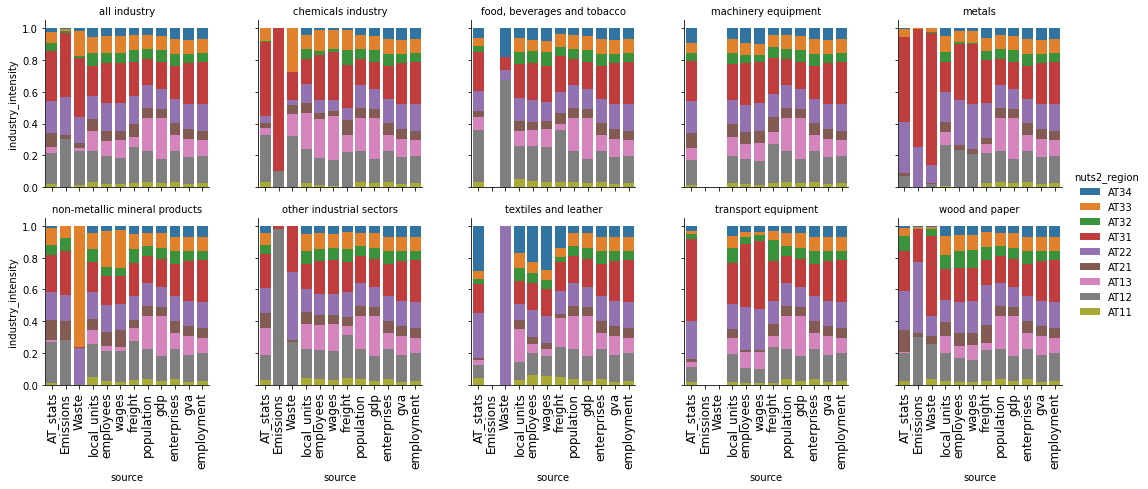

In [274]:
g = sns.FacetGrid(
    all_indicators.append(all_indicators_sum.to_frame('industry_intensity').assign(subsector='all industry').reset_index())
    .set_index(['source', 'subsector', 'nuts2_region'])
    ['industry_intensity']
    .unstack('nuts2_region')
    .cumsum(axis=1)
    .stack()
    .to_frame('industry_intensity')
    .reset_index(),
    col='subsector',
    hue='nuts2_region',
    hue_order=all_indicators.nuts2_region.unique()[::-1],
    col_wrap=5,
)
g.map(sns.barplot, 'source', 'industry_intensity', order=all_indicators.source.unique())
g.add_legend()

g.set_titles(col_template = '{col_name}')
foo = [ax.set_xticklabels(all_indicators.source.unique(), rotation=90, ha='center', size=12) for ax in g.axes.flat]

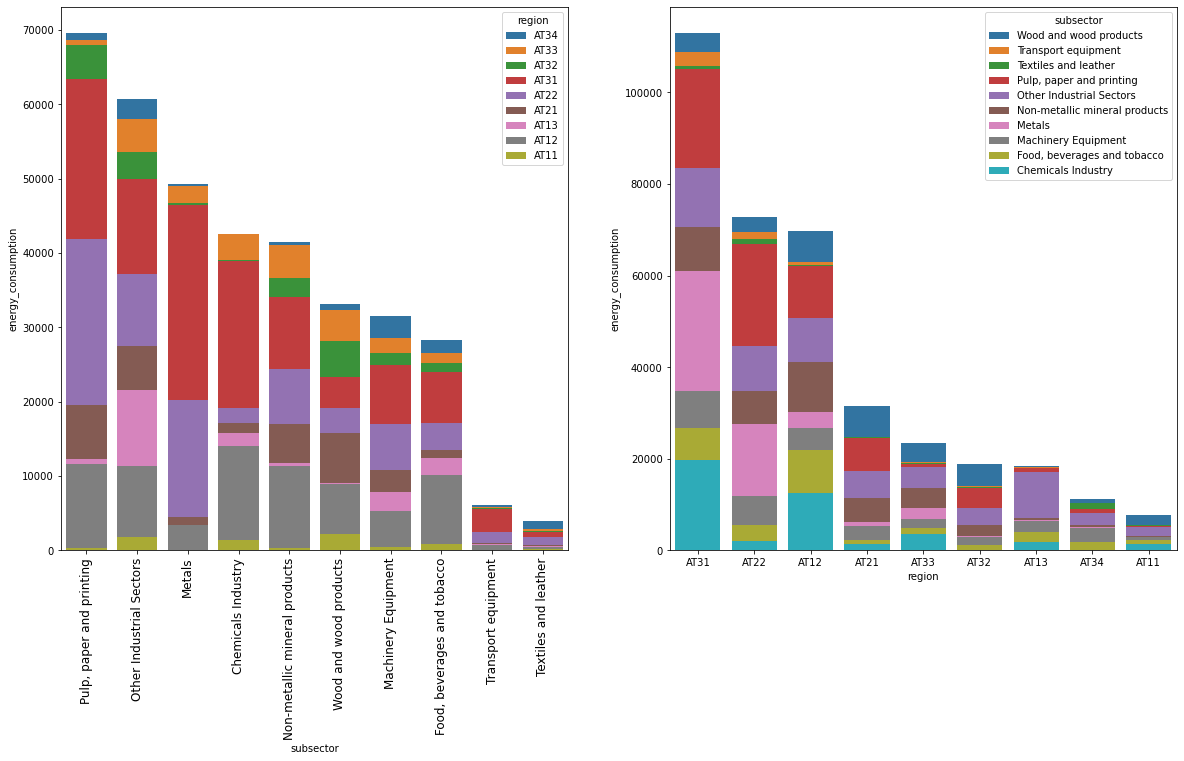

In [248]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.barplot(
    data=at_stats.cumsum(axis=1).stack().to_frame('energy_consumption').reset_index(),
    x='subsector',
    y='energy_consumption',
    hue='region',
    hue_order=at_stats.columns[::-1],
    order=at_stats.sum(axis=1).sort_values(ascending=False).index,
    dodge=False,
    ax=ax[0]
)
ax[0].set_xticklabels(at_stats.sum(axis=1).sort_values(ascending=False).index, rotation=90, ha='center', size=12)
sns.barplot(
    data=at_stats.cumsum(axis=0).stack().to_frame('energy_consumption').reset_index(),
    x='region',
    y='energy_consumption',
    hue='subsector',
    hue_order=at_stats.index[::-1],
    order=at_stats.sum(axis=0).sort_values(ascending=False).index,
    dodge=False,
    ax=ax[1]
)

# Look at freight on a Euro-Calliope regional level

In [658]:
freight_at_nuts3 = freight.groupby([freight_sectors, {idx: idx for idx in nuts3.set_index('id').index}], level=[0, 2]).sum()['2014 '].unstack('region')
freight_at_nuts3_gdf = gpd.GeoDataFrame(geometry=nuts3.set_index('id').geometry, data=freight_at_nuts3.T.reindex(nuts3.id), crs=)
euro_calliope_clusters = gpd.read_file('../build/units.geojson')

In [662]:
gpd.GeoDataFrame(freight_at_nuts3_gdf.to_crs('epsg:3035').centroid).crs

In [676]:
euro_calliope_id = gpd.overlay(
    gpd.GeoDataFrame(data=freight_at_nuts3_gdf.assign(id=freight_at_nuts3_gdf.index).id, 
                     geometry=freight_at_nuts3_gdf.to_crs('epsg:3035').centroid, crs='epsg:3035'),
    euro_calliope_clusters.to_crs('epsg:3035')
).set_index('id_1').id_2

In [679]:
freight_at_nuts3_gdf.assign(euro_calliope=euro_calliope_id).groupby('euro_calliope').sum()

subsector,Chemicals Industry,"Food, beverages and tobacco",Machinery Equipment,Metals,Non-metallic mineral products,Other Industrial Sectors,Textiles and leather,Transport Equipment,Wood and paper
euro_calliope,,,,,,,,,
AUT_1,749.0,5371.0,390.0,1706.0,10381.0,39765.0,198.0,843.0,6421.0
AUT_2,1258.0,8954.0,662.0,3766.0,15827.0,54674.0,262.0,1291.0,11212.0
AUT_3,972.0,9528.0,560.0,2034.0,14665.0,56022.0,337.0,957.0,6217.0


# Commercial demand

In [25]:
# Extract Austrian data
def get_at_end_use_df(year=None, region=None):
    files = {
        'AT': '066288',  # NUTS0
        'AT11': '066289',  # NUTS2
        'AT12': '066291',  # NUTS2
        'AT13': '066297',  # NUTS2
        'AT21': '066290',  # NUTS2
        'AT22': '066294',  # NUTS2
        'AT31': '066292',  # NUTS2
        'AT32': '066293',  # NUTS2
        'AT33': '066295',  # NUTS2
        'AT34': '066296'  # NUTS2
    }
    if region is not None:
        files = {region: files[region]}
    if year is not None:
        years = [year]
    else:
        years = range(2005, 2018)
    end_uses = []
    
    for region, filecode in files.items():
        for year in years:
            _end_use_demand = pd.read_excel(
                f'https://www.statistik.at/wcm/idc/idcplg?IdcService=GET_NATIVE_FILE&RevisionSelectionMethod=LatestReleased&dDocName={filecode}', 
                sheet_name=f'NEA {year}', usecols="K:S", skiprows=30, header=None
            ).dropna(how='all', subset=range(12, 19))
            table_ends = _end_use_demand[_end_use_demand[10] == 'Peat'].index
            dfs = []

            for i in range(0, len(table_ends)):
                if i == 0:
                    _df = _end_use_demand.loc[:table_ends[i] + 1]
                else:
                    _df = _end_use_demand.loc[table_ends[i - 1] + 1:table_ends[i] + 1]

                _df = _df.set_index(10).drop(['Shares', 'TOTAL', 0], errors='ignore')
                _df.columns = _df.iloc[0].values
                _df.rename(
                    columns={'Indust. furnaces': 'Industrial furnaces',
                            'of which electochemical purp.': 'of which electochemical purposes'}, 
                    inplace=True
                )
                _df.index.set_names('carrier_name', inplace=True)
                _df = _df.assign(cat_name=_df.iloc[0].name)
                _df = _df.drop(_df.iloc[0].name).drop('Total', axis=1)
                _df.columns = (
                    _df.columns
                    .str.lower()
                    .str.replace("of which ", "")
                    .str.replace(" & ", "_")
                    .str.replace(" ", "_")
                )
                _df = _df.set_index('cat_name', append=True)

                dfs.append(_df)
            end_uses.append(
                pd.concat(dfs, sort=True)
                .sort_index()
                .assign(region=region, year=year, unit='TJ')
                .set_index(['region', 'year', 'unit'], append=True)
            )
    return pd.concat(end_uses, sort=True)

In [26]:
_df = get_at_end_use_df(year=2014)

In [28]:
com_df = pd.concat(
    [_df.xs('Commercial and public services', level=1).drop('AT', level=1).sum(level=['region'])['space_heating_and_air_condition'],
     population_df,
     gdp_df,
     gva_df.xs('MIO_EUR').loc[idx[['G-J', 'K-N', 'O-U'], nuts2.id], :]['2014 '].unstack().sum(),
     employment_df.xs(('THS', 'EMP')).loc[idx[['G-J', 'K-N', 'O-U'], nuts2.id], 2014].unstack().sum(),
     enterprises_df.xs('V11910').loc[idx['G':, nuts2.id], :].apply(util.to_numeric)[2014].unstack().sum(),
     industry_activity.xs('V11210', level='indicator').apply(util.to_numeric).loc[idx[['G', 'H', 'I', 'J', 'L', 'M', 'N', 'S95'], nuts2.id.values], :].sum(level=1)['2014 '],
     industry_activity.xs('V16110', level='indicator').apply(util.to_numeric).loc[idx[['G', 'H', 'I', 'J', 'L', 'M', 'N', 'S95'], nuts2.id.values], :].sum(level=1)['2014 '],
     industry_activity.xs('V13320', level='indicator').apply(util.to_numeric).loc[idx[['G', 'H', 'I', 'J', 'L', 'M', 'N', 'S95'], nuts2.id.values], :].sum(level=1)['2014 ']
    ],
    names=['source'], keys=['AT_stats', 'population', 'gdp', 'gva', 'employment', 'enterprises', 'local_units', 'employees', 'wages']
).apply(pd.to_numeric, errors='coerce')
com_intensity_df = com_df.div(com_df.sum(level='source'))

In [31]:
com_intensity_df

source    region
AT_stats  AT11      0.018737
          AT12      0.182787
          AT13      0.272579
          AT21      0.078066
          AT22      0.107615
                      ...   
wages     AT22      0.110932
          AT31      0.148008
          AT32      0.080453
          AT33      0.084351
          AT34      0.036071
Length: 81, dtype: float64

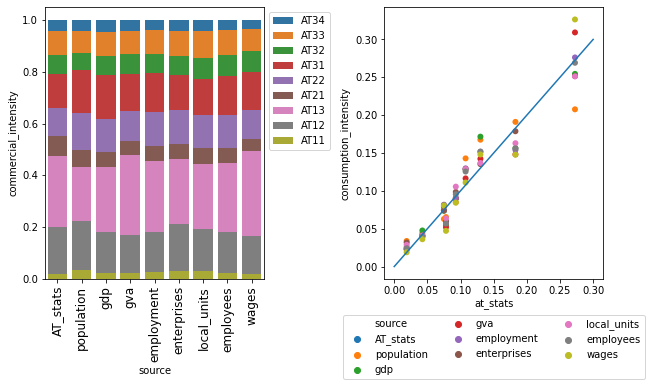

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.55})
sns.barplot(
    data=com_intensity_df
    .unstack()
    .cumsum(axis=1)
    .stack()
    .to_frame('commercial_intensity')
    .reset_index(),
    x='source',
    y='commercial_intensity',
    hue='region',
    hue_order=com_intensity_df.index.levels[1][::-1],
    dodge=False,
    ax=ax[0]
)
ax[0].legend(bbox_to_anchor=(1, 1))
ax[0].set_xticklabels(com_intensity_df.index.levels[0], rotation=90, ha='center', size=12)

sns.scatterplot(
    data=com_intensity_df
    .drop('AT_stats')
    .to_frame('consumption_intensity')
    .assign(at_stats=np.tile(com_intensity_df.xs('AT_stats').values, len(com_intensity_df.drop('AT_stats').unstack(1).values)))
    .reset_index(),
    x='at_stats',
    y='consumption_intensity',
    hue='source',
    hue_order=com_intensity_df.drop('AT_stats').index.levels[0],
    edgecolor='None',
    ax=ax[1]
)
ax[1].legend(bbox_to_anchor=(0.5, -0.25), loc='center', ncol=3)
ax[1].add_line(mlines.Line2D([0, 0.3], [0, 0.3]))

In [54]:
com_intensity_df.unstack(0).corr()


source,AT_stats,population,gdp,gva,employment,enterprises,local_units,employees,wages
source,,,,,,,,,
AT_stats,1.000000,0.919003,0.959649,0.973293,0.976663,0.986671,0.984181,0.978054,0.968803
population,0.919003,1.000000,0.953982,0.879770,0.929321,0.953670,0.937352,0.931052,0.870723
gdp,0.959649,0.953982,1.000000,0.971605,0.990841,0.976170,0.980767,0.991693,0.968727
gva,0.973293,0.879770,0.971605,1.000000,0.991856,0.970456,0.980650,0.990403,0.999267
employment,0.976663,0.929321,0.990841,0.991856,1.000000,0.985730,0.992303,0.998746,0.988556
enterprises,0.986671,0.953670,0.976170,0.970456,0.985730,1.000000,0.995610,0.987427,0.963445
local_units,0.984181,0.937352,0.980767,0.980650,0.992303,0.995610,1.000000,0.994704,0.974263
employees,0.978054,0.931052,0.991693,0.990403,0.998746,0.987427,0.994704,1.000000,0.987225
wages,0.968803,0.870723,0.968727,0.999267,0.988556,0.963445,0.974263,0.987225,1.000000


In [52]:
model = sm.OLS(com_intensity_df.xs('AT_stats'), com_intensity_df.loc[['gva', 'enterprises']].unstack(0))

,country_code,id,name,type,proper,geometry,nuts2
0,AUT,AT111,Mittelburgenland,None,True,"MULTIPOLYGON (((16.64622 47.44660, 16.63631 47...",AT11
1,AUT,AT112,Nordburgenland,None,True,"MULTIPOLYGON (((17.16080 48.00666, 17.14890 48...",AT11
2,AUT,AT113,Südburgenland,None,True,"MULTIPOLYGON (((16.43371 47.35282, 16.43600 47...",AT11
3,AUT,AT121,Mostviertel-Eisenwurzen,None,True,"MULTIPOLYGON (((15.50768 48.31960, 15.51012 48...",AT12
4,AUT,AT122,Niederösterreich-Süd,None,True,"MULTIPOLYGON (((15.91586 48.08854, 15.91606 48...",AT12
5,AUT,AT123,Sankt Pölten,None,True,"MULTIPOLYGON (((15.99565 48.14571, 15.96240 48...",AT12
6,AUT,AT124,Waldviertel,None,True,"MULTIPOLYGON (((15.54236 48.90796, 15.55353 48...",AT12
7,AUT,AT125,Weinviertel,None,True,"MULTIPOLYGON (((16.94120 48.61700, 16.93934 48...",AT12
8,AUT,AT126,Wiener Umland/Nordteil,None,True,"MULTIPOLYGON (((16.85121 48.43863, 16.85164 48...",AT12
9,AUT,AT127,Wiener Umland/Südteil,None,True,"MULTIPOLYGON (((16.97624 48.17223, 16.98840 48...",AT12


In [180]:
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              513.9
Date:                Mon, 17 Aug 2020   Prob (F-statistic):                    2.55e-08
Time:                        11:10:55   Log-Likelihood:                          27.884
No. Observations:                   9   AIC:                                     -51.77
Df Residuals:                       7   BIC:                                     -51.37
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
gva             0.2746      0.187      1.467      0.186      -0.168       0.717
enterprises     0.7311      0.199      3.683      0.008       0.262       1.201
==============================================================================
Omnibus:                        0.318   Durbin-Watson:                   2.292
Prob(Omnibus):                  0.853   Jarque-Bera (JB):                0.245
Skew:                           0.293   Prob(JB):                        0.885
Kurtosis:                       2.441   Cond. No.                         12.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [265]:
all_indicators_sum.xs('Emissions')

nuts2_region
AT11    0.000216
AT12    0.302504
AT21    0.028136
AT22    0.239064
AT31    0.398281
AT32    0.012889
AT33    0.015403
AT34    0.003508
dtype: float64

In [267]:
all_indicators_sum.xs('employment')

nuts2_region
AT11    0.026424
AT12    0.172343
AT13    0.101879
AT21    0.060628
AT22    0.165884
AT31    0.258808
AT32    0.059748
AT33    0.086171
AT34    0.068115
dtype: float64